In [75]:
import toml
import sys
sys.path = ["/scratch/x77/ahg157/software/python-ale/build/lib.linux-x86_64-3.9"] + sys.path
import pyale
from dask.distributed import Client
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import cmocean as cm


## Load grid information into dataset

In [17]:
ds = xr.open_dataset('/scratch/x77/amh157/mom6/archive/zstar/output300/ocean_static.nc')
ds

<xarray.Dataset>
Dimensions:       (xh: 160, yh: 800, time: 1, xq: 161, yq: 801)
Coordinates:
  * xh            (xh) float64 0.125 0.375 0.625 0.875 ... 39.38 39.63 39.88
  * yh            (yh) float64 -70.15 -70.07 -69.98 -69.89 ... 69.98 70.07 70.15
  * time          (time) object 0001-01-01 00:00:00
  * xq            (xq) float64 0.0 0.25 0.5 0.75 1.0 ... 39.25 39.5 39.75 40.0
  * yq            (yq) float64 -70.19 -70.11 -70.02 -69.94 ... 70.02 70.11 70.19
Data variables: (12/25)
    areacello     (yh, xh) float32 ...
    deptho        (yh, xh) float32 ...
    sftof         (yh, xh) float32 ...
    Coriolis      (yq, xq) float32 ...
    geolon        (yh, xh) float32 ...
    geolat        (yh, xh) float32 ...
    ...            ...
    dyCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dyCv          (yq, xh) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
Attributes:
    NumFilesInSet:  1
    title:          ANU_tub Sector
    grid_type:      regular
    grid_tile:      N/A

In [23]:
restart_filename = '/scratch/x77/amh157/mom6/archive/zstar/restart300/MOM.res.nc'
ds2 = xr.open_dataset(restart_filename)

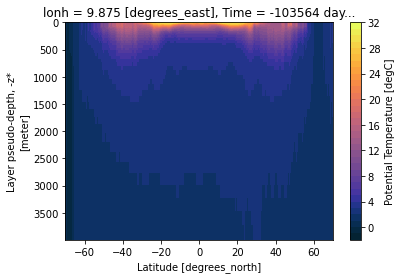

In [76]:
vlev = np.linspace(-2,32,35)
ds2.Temp.isel(Time=0).isel(lonh=39).plot(levels=vlev,cmap=cm.cm.thermal)
plt.gca().invert_yaxis()

## Start with Adaptive case

In [66]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_adapt.toml")
cs = pyale.mom_init_cs(params)

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  F
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  F
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                              NIPROC:            1
 MOM_domains                              NJPROC:            1
 MOM_domains                              LAYOUT:     

In [67]:
pyale.load_mom_restart(cs, restart_filename)
adapt_cs = pyale.mom_init_regrid(cs, params, "ADAPTIVE")
(h, temp, salt) = pyale.accelerate_ale(cs, adapt_cs, iter=100, dt=3600)

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  F
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'FNC1:2,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0000000000000000        2.0099999999999998        2.0099999999999998        2.0200000000000000        2.0299999999999998        2.0499999999999998        2.0800000000000001        2.1099999999999999        2.1499999999999999        2.2100000000000000        2.2800000000000002        2.3700000000000001        2.4800000000000000        2.6099999999999999        2.7700000000000000        2.9500000000000002     

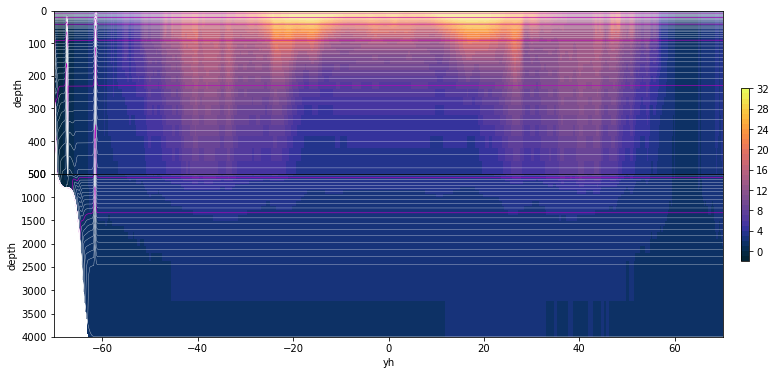

In [78]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))
            #attrs= u.attrs)
    
plt.figure(figsize=(12,6))
plt.subplot(211)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.gca().invert_yaxis()
    
plt.subplot(212)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([500,4000])
plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0)

ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)

## HYCOM1 case

In [80]:
params = toml.load("/g/data/x77/amh157/anu-tub/diagnostics/params_hycom1.toml")
params["MIN_THICKNESS"] = 1e-03
params["MAXIMUM_INT_DEPTH_CONFIG"] = "FNC1:5,8000.0,1.0,.01"
params["MAX_LAYER_THICKNESS_CONFIG"] = "FNC1:400,31000.0,0.1,.01"
params["BOUNDARY_EXTRAPOLATION"] = True
cs = pyale.mom_init_cs(params)

 log_version: MOM_domains                             , unknown
 MOM_domains                              REENTRANT_X:  F
 MOM_domains                              REENTRANT_Y:  F
 MOM_domains                              TRIPOLAR_N:  F
 MOM_domains                              !SYMMETRIC_MEMORY_:  T
 MOM_domains                              NONBLOCKING_UPDATES:  F
 MOM_domains                              THIN_HALO_UPDATES:  F
 MOM_domains                              !STATIC_MEMORY_:  F
 MOM_domains                              NIGLOBAL:          160
 MOM_domains                              NJGLOBAL:          800
 MOM_domains                              NIHALO:            4
 MOM_domains                              NJHALO:            4
 MOM_domains                              MASKTABLE: 'MOM_mask_table'
 MOM_domains                              NIPROC:            1
 MOM_domains                              NJPROC:            1
 MOM_domains                              LAYOUT:     

In [81]:
pyale.load_mom_restart(cs, restart_filename)
hycom1_cs = pyale.mom_init_regrid(cs, params, "HYCOM1")
(h, temp, salt) = pyale.accelerate_ale(cs, hycom1_cs, iter=1)

 init_MOM_state INPUTDIR: '/g/data/x77/amh157/mom6/input/anu-tub'
 init_MOM_state REGRIDDING_COORDINATE_UNITS: 'm'
 init_MOM_state INTERPOLATION_SCHEME: 'P1M_H2'
 init_MOM_state DEFAULT_2018_ANSWERS:  F
 init_MOM_state REMAPPING_2018_ANSWERS:  F
 init_MOM_state BOUNDARY_EXTRAPOLATION:  T
 init_MOM_state ALE_COORDINATE_CONFIG                   : 'HYBRID:hycom1_75_800m.nc,sigma2,FNC1:1.08,4000,4.5,.01'
 init_MOM_state !ALE_RESOLUTION                          :    1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0800000000000001        1.0900000000000001        1.0900000000000001        1.1000000000000001        1.1100000000000001        1.1300000000000001        1.1600000000000001        1.1900000000000002        1.2400000000000000        1.2900000000000000        1.3700000000000001        1.4500000000000002        1.5600000000000001        1.7000000000000002        1.860000000000

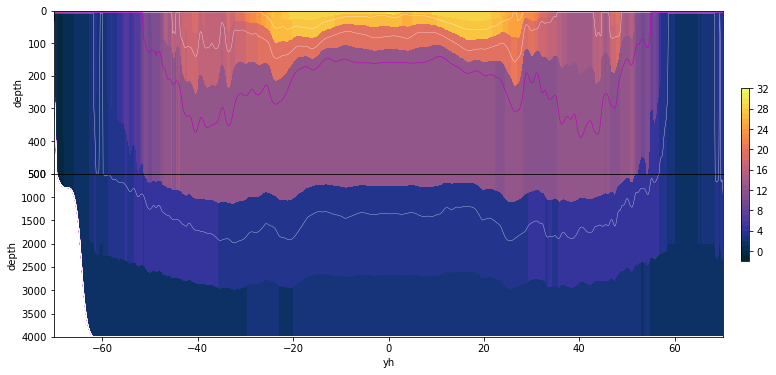

In [82]:
h_depth = np.cumsum(h[39,:,:],1)
new_temp = xr.DataArray(data=np.transpose(temp[39,:,:]),dims=["zl", "yh"],
            coords=dict(yh=(["yh"], ds2.lath.values),depth=(["zl", "yh"], np.transpose(h_depth))))
            #attrs= u.attrs)
    
plt.figure(figsize=(12,6))
plt.subplot(211)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([0,500])
plt.gca().invert_yaxis()
    
plt.subplot(212)
p1 = new_temp.plot(y = "depth",add_colorbar=False,levels=vlev,cmap=cm.cm.thermal)
for ii in range(75):
    if np.mod(ii,10)==5:
        plt.plot(ds2.lath.values,h_depth[:,ii],'m',linewidth=0.6)
    else:
        plt.plot(ds2.lath.values,h_depth[:,ii],'w',linewidth=0.3)
plt.ylim([500,4000])
plt.gca().invert_yaxis()
    
plt.subplots_adjust(hspace=0)

ax_c = plt.axes([0.92,0.3,0.01,0.4])
plt.colorbar(p1,ax_c)